## 等間隔にRGBを配置し、OKLAB, OKLCHへ変換
動作チェックを兼ねて等間隔に配置したRGBを用意し、これをOKLAB, OKLCHへ座標変換してみる

-> [OKLCH](https://oklch.com/#70,0.1,356,100)の立体と同じようにプロットがされたのでクリア


## sRGBからOKLCHへの変換手順

sRGBからOKLCHへの変換は、いくつかの色空間を経由して色の値を変換するプロセスです。具体的には、以下の手順で行います。

### 1. sRGBからリニアRGBへの変換

sRGBの値はガンマ補正されているため、リニアRGBに戻す必要があります。この変換では、以下の式を用います。

1. sRGBの各成分（通常0〜255の範囲）を0〜1に正規化します。
2. 正規化された各色成分 (R, G, B) に対して次の条件分岐を適用します:

   $$
   C_{\text{linear}} = \frac{C_{\text{srgb}}}{12.92} \quad (\text{if } C_{\text{srgb}} \leq 0.04045)
   $$

   $$
   C_{\text{linear}} = \left( \frac{C_{\text{srgb}} + 0.055}{1.055} \right)^{2.4} \quad (\text{if } C_{\text{srgb}} > 0.04045)
   $$

これにより、sRGBの値がリニアRGBに変換されます。

### 2. リニアRGBからCIE 1931 XYZへの変換

リニアRGBからCIE XYZに変換します。XYZは、色を数学的に取り扱いやすくするための中間色空間です。XYZへの変換には以下の行列を用います。

$$
\begin{bmatrix}
X \\
Y \\
Z
\end{bmatrix}
=
\begin{bmatrix}
0.4124564 & 0.3575761 & 0.1804375 \\
0.2126729 & 0.7151522 & 0.0721750 \\
0.0193339 & 0.1191920 & 0.9503041
\end{bmatrix}
\begin{bmatrix}
R_{\text{linear}} \\
G_{\text{linear}} \\
B_{\text{linear}}
\end{bmatrix}
$$

この行列乗算により、リニアRGBからXYZの色空間に変換されます。

### 3. XYZからLabへの変換

次に、XYZからCIE Lab色空間に変換します。Lab色空間は、人間の視覚に基づいた色表現を行うための色空間です。変換には次の式を使います。

1. **規格化**: 各成分 \(X, Y, Z\) を基準値で規格化します。通常のD65の基準値は以下の通りです。

   $$
   X_{\text{ref}} = 95.047, \quad Y_{\text{ref}} = 100.000, \quad Z_{\text{ref}} = 108.883
   $$

   規格化された成分は以下のように計算されます。

   $$
   \hat{X} = \frac{X}{X_{\text{ref}}}, \quad \hat{Y} = \frac{Y}{Y_{\text{ref}}}, \quad \hat{Z} = \frac{Z}{Z_{\text{ref}}}
   $$

2. **f関数の定義**:

   $$
   f(t) = \begin{cases} 
   t^{1/3} & \text{if } t > \delta^3 \\
   \frac{t}{3\delta^2} + \frac{4}{29} & \text{otherwise}
   \end{cases}
   $$

   ここで、\(\delta = \frac{6}{29}\) です。

3. **Lab成分の計算**:

   $$
   L^* = 116 \cdot f(\hat{Y}) - 16
   $$

   $$
   a^* = 500 \cdot \left( f(\hat{X}) - f(\hat{Y}) \right)
   $$

   $$
   b^* = 200 \cdot \left( f(\hat{Y}) - f(\hat{Z}) \right)
   $$

### 4. LabからOKLCHへの変換

LabからOKLCHへ変換するには、OKLab色空間に変換してから極座標に変換します。

#### 4.1 LabからOKLabへの変換

LabからOKLabへの変換には、以下の線形変換を行います。

$$
\begin{bmatrix}
L_{\text{ok}} \\
a_{\text{ok}} \\
b_{\text{ok}}
\end{bmatrix}
=
\begin{bmatrix}
0.2104542553 & 0.7936177850 & -0.0040720468 \\
1.9779984951 & -2.4285922050 & 0.4505937099 \\
0.0259040371 & 0.7827717662 & -0.8086757660
\end{bmatrix}
\begin{bmatrix}
L^* \\
a^* \\
b^*
\end{bmatrix}
$$

#### 4.2 OKLabからOKLCHへの変換

OKLabからOKLCHに変換するためには、次のように極座標系に変換します。

- **クロマ (C)**:

  $$
  C = \sqrt{a_{\text{ok}}^2 + b_{\text{ok}}^2}
  $$

- **色相 (H)**:

  $$
  H = \text{atan2}(b_{\text{ok}}, a_{\text{ok}})
  $$

  色相 \( H \) は通常ラジアンで計算されますが、度数に変換する場合は以下の式を用います。

  $$
  H_{\text{degrees}} = \frac{H}{\pi} \times 180
  $$

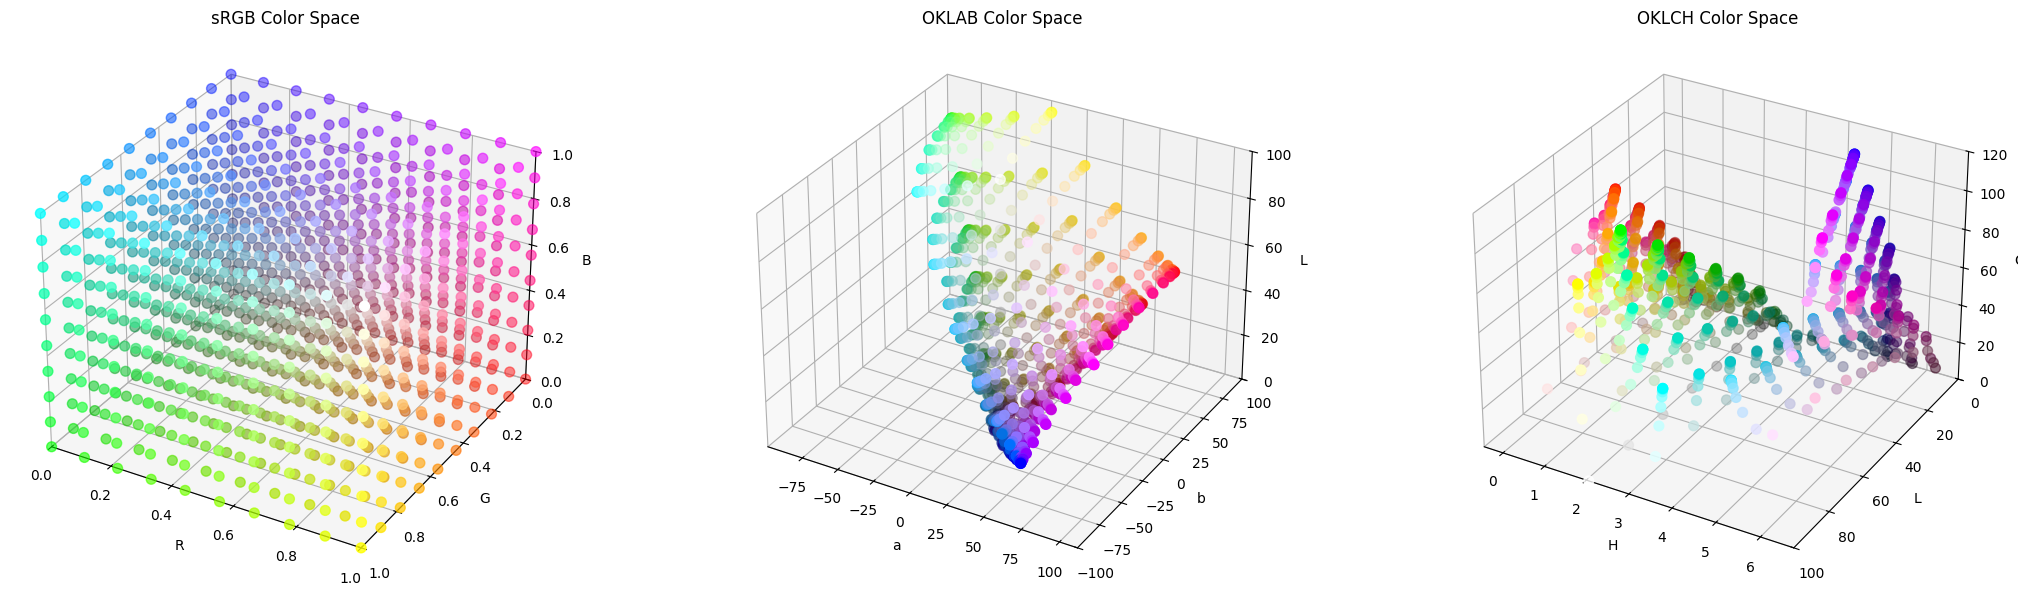

In [7]:
import json
from scripts.color3d import process_color_palette, plot_color_spaces, generate_equal_interval_palette, rgb_to_oklab, \
    oklab_to_oklch
import numpy as np

POINT_SIZE = 50

equal_interval_rgb_colors = generate_equal_interval_palette()
equal_interval_oklab_colors = np.array([rgb_to_oklab(color) for color in equal_interval_rgb_colors])
equal_interval_oklch_colors = np.array([oklab_to_oklch(oklab) for oklab in equal_interval_oklab_colors])
plot_color_spaces(equal_interval_rgb_colors, equal_interval_oklab_colors, equal_interval_oklch_colors, POINT_SIZE)

## カラーパレットから抽出した値をプロットしてみる
用意したカラーパレットのデータをもとに空間にプロットする

今回、[ColorHunt](https://colorhunt.co/)からパレット(4色1セット)を3000件ほど抽出して、これをsRGB, OKLAB, OKLCHにプロットした

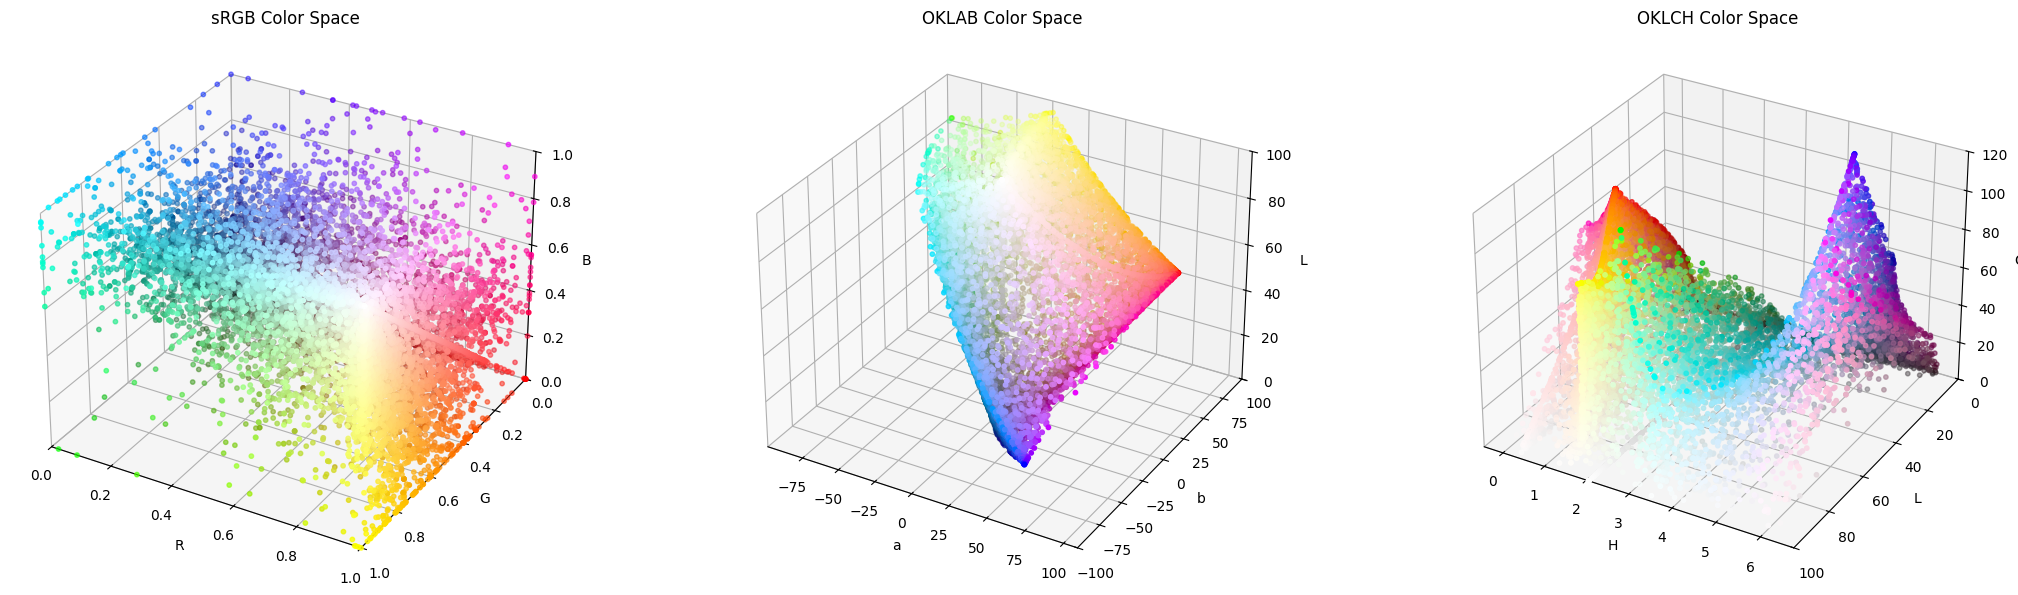

In [5]:
import json
from scripts.color3d import process_color_palette, plot_color_spaces, generate_equal_interval_palette, rgb_to_oklab, \
    oklab_to_oklch
import numpy as np

POINT_SIZE = 10

if __name__ == "__main__":
    # Load color palette from JSON file
    with open('../data/raw/rgbPalette.json', 'r') as file:
        palette = json.load(file)
rgb_colors, oklab_colors, oklch_colors = process_color_palette(palette)
plot_color_spaces(rgb_colors, oklab_colors, oklch_colors)


## OKLCHのHueでスライスして観察してみる
今のところわかること

- 赤系, 黄色系のカラーが使われることが多そう
- 一方で、水色系, ピンク系統は少し少ないかも?
  - 180~270degあたりは、青系ということで変化の差が少ないことも影響しているかもしれない
- 極端に明るい / 極端に暗いものは使用されにくそう

ただし、この分析ではまだ組み合わせに関係なく、純粋にどの色が使われているかくらいでわかることは少なそう

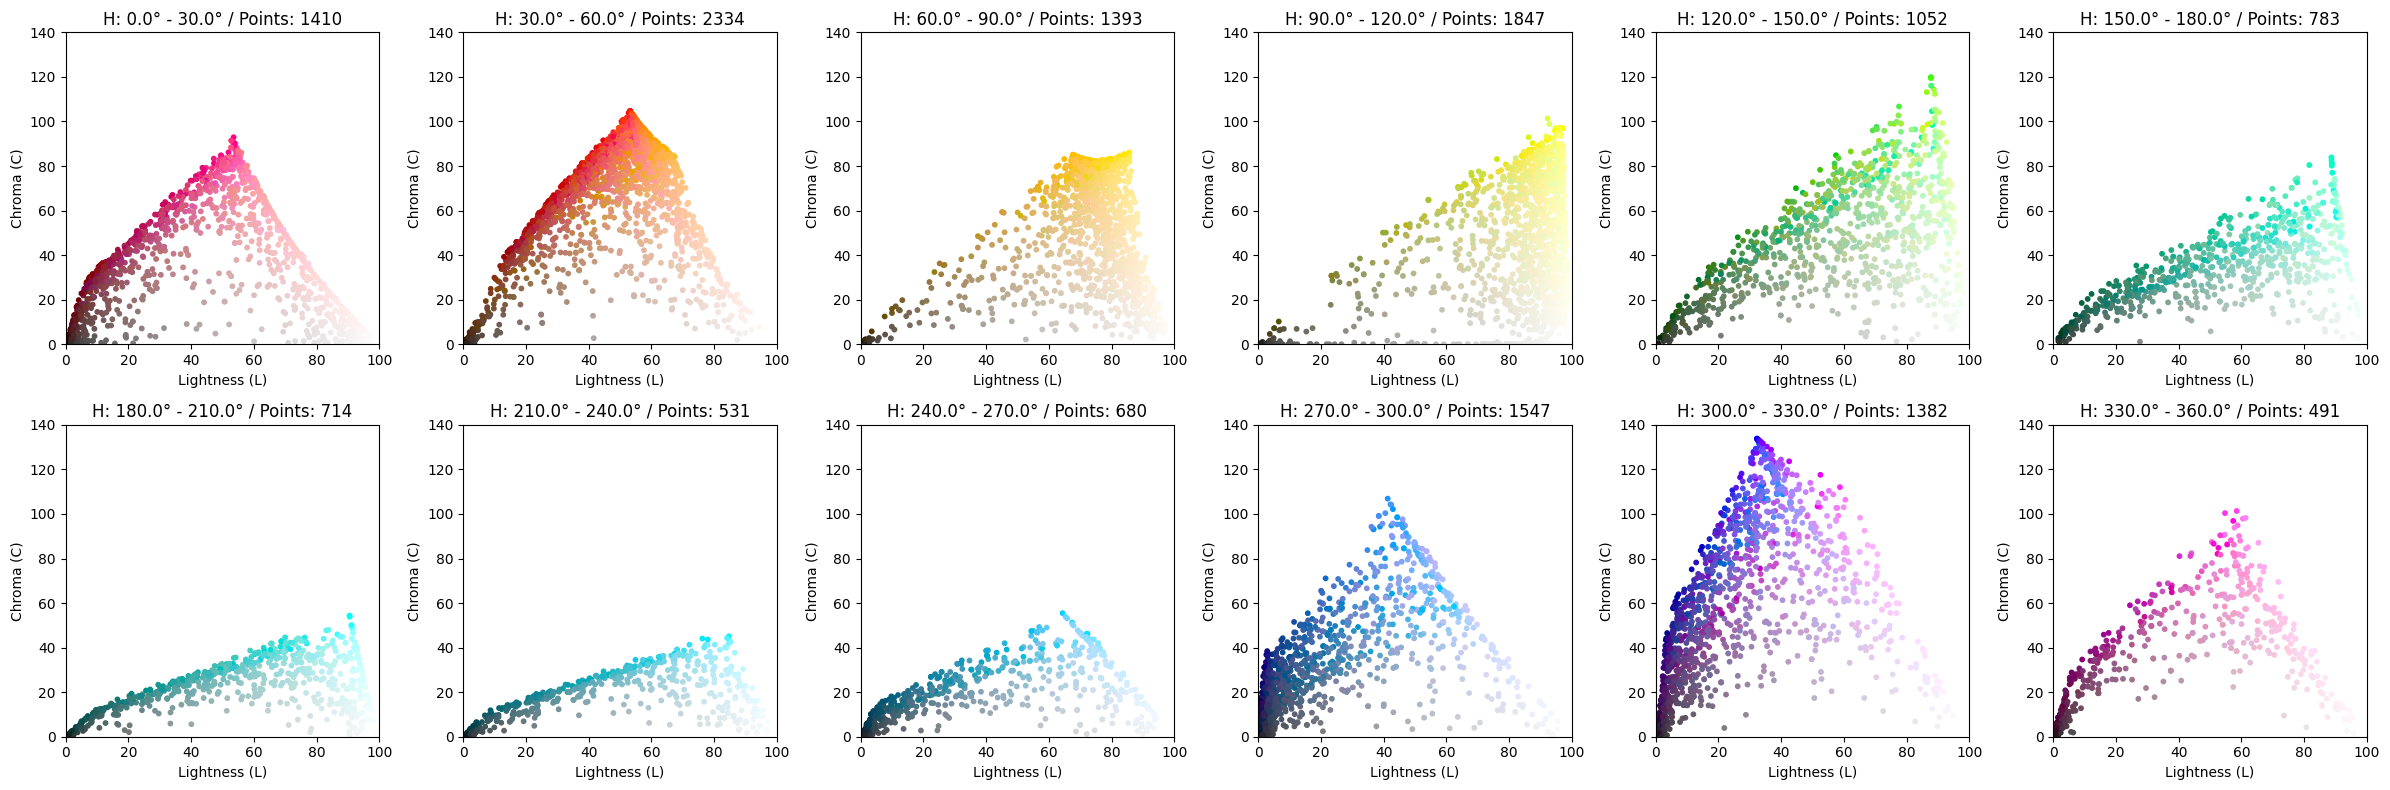

In [1]:
import json
from scripts.color3d import plot_oklch_segments, process_color_palette
import numpy as np

POINT_SIZE = 10
FIGURE_SIZE = (24, 8)

# Load color palette from JSON file
with open('../data/raw/rgbPalette.json', 'r') as file:
    palette = json.load(file)

# Process the color palette
rgb_colors, oklab_colors, oklch_colors = process_color_palette(palette)

# Plot OKLCH H-segments
plot_oklch_segments(oklch_colors, rgb_colors, POINT_SIZE, FIGURE_SIZE)